## Solving dynamic finite-horizon optimisation problems recursively

In [3]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

---

### Problem Setup

The basic problem structure is as follows:
$$\underset{{K_{t+1}, I_t}}{max} \sum^T_{t=0}\beta^t h(K_t, I_t)$$
$$s.t. \: K_{t+1} = f(K_t,I_t) \: \forall t$$
This can be thought of as representing the problem of optimal investment in capabilities to maximise present discounted value of happiness across the lifespan

The objective is to find functions $h, f$ such that the optimal happiness trajectory $h(\tilde{K}_{t+1}, \tilde{I}_t)$ is U-shaped

---

### Problem Intuition

My intuition of the problem given these constraints is that they should lead people to want to avoid going into old age with a low capability stock because this will be very costly in terms of happiness (as it is harder to improve upon capabilities in old age). They therefore need it to be high, and the most efficient way to do that is to invest in midlife, then gradually taper off into old age.
- this fits with what seems to be the case in reality: people spend a lot of their young to mid adult life finding a partner, raising a family, working hard and climbing the corporate ladder etc, until they eventually retire, the children grow up etc and they are able to reap the rewards for these 'investments'.

It is important to realise the investment schedule we are trying to generate in order to get this happiness U-shape: starts low, then increases, then plateaus/decreases. It is worth thinking about the problem in these terms too.

Also note that initial capabilities should probably initially be high, because your family are giving them to you - this may mean we should be prioritising larger values of $c_0$.

Question: what is stopping individuals in this model from just accepting that old age will be a period of unhappiness because it is costly to maintain happiness at this stage? This is the key alternative option, which seems to be preferred by most of the model setups

---

### Numerical Solution

Start by defining a function that solves the finite-horizon optimisation problem numerically via backward induction, and then simulates the solution trajectory from a specified starting point 

In [35]:
def solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next):

    # these arguments correspond to:
        # K0: initial capital
        # Kmin, Kmax: min and max of K_grid
        # nK: number of grid points for K
        # Imin, Imax: min and max of I_grid
        # nI: number of grid points for I
        # Tsim: number of time periods to simulate
        # gamma_path: array of length Tsim with investment cost parameter for each t
        # delta_path: array of length Tsim with depreciation rate for each t
        # A, alpha, beta: model parameters
        # h_of_t: the function h(K,I,t) that computes period payoff (evaluated on a grid of different values of I)
        # K_next: function to compute next period capital

    #### SET UP THE GRID TO DO THE OPTIMISATION OVER

    # set the state and control grids
    K_grid = np.linspace(Kmin, Kmax, nK)
    I_grid = np.linspace(Imin, Imax, nI)

    #### DO BACKWARD INDUCTION TO SOLVE THE TIME-DEPENDENT PROBLEM

    # V[t, iK] will hold value at time t for K_grid[iK]
    # V[Tsim,:] is terminal value = 0 (i.e. no continuation value beyond this point)
    V = np.zeros((Tsim + 1, nK))

    # policy_I_idx[t, iK] will hold index of optimal I in I_grid for each (t, K_grid[iK])
    policy_I_idx = np.zeros((Tsim, nK), dtype=int)

    # now start the backwards loop that calculates V and policy_I_idx for the prior period, given V in the next
    # note that we keep V[Tsim, :] = 0 as the terminal condition: this is the transversality condition (TVC)

    for t in range(Tsim - 1, -1, -1):  # i.e. t = Tsim-1, ..., 0

        # create interpolator for V[t+1, .], taking the values of V for each K in K_grid and linearly interpolating
        Vnext_interp = interp1d(K_grid, V[t + 1], kind='linear', fill_value='extrapolate', assume_sorted=True)

        # loop across K grid to get the V and the policy I for each value of K
        for iK, K in enumerate(K_grid):

            # compute feasible K' for each candidate I (giving a vector) and the given K
            Knext = K_next(K, I_grid, t)

            # clip onto interpolation domain (i.e. if K>Kmax then set to Kmax, and same for Kmin)
            Knext_clipped = np.clip(Knext, Kmin, Kmax)

            # calculate continuation value (i.e. next period V) for each candidate I, given the corresponding K'
            cont_val = Vnext_interp(Knext_clipped)        # V[t+1](K') vector of length nI

            # calculate the immediate payoff vector for all candidate I (again a vector of length nI)
            h_vec = h_of_t(K, I_grid, t)

            # get the total RHS value of the Bellman equation, and then the index of the I that maximises it
            total = h_vec + beta * cont_val               # total value for each I
            jstar = int(np.argmax(total))                 # index of best I

            # store the value and policy function index for the given K
            V[t, iK] = total[jstar]
            policy_I_idx[t, iK] = jstar

        # after looping over all K, we have found the optimal investment function and the value function in time t given K_t
        # the value function is then used in the next loop to get the next period's functions, and so on

        # print the progress
        if (t % 10) == 0:
            print(f'Backward step done: t={t}')

    print('Backward induction finished.')

    # -------------------------
    # Build time-dependent policy function objects for simulation
    # -------------------------
    policy_I_vals = I_grid[policy_I_idx]   # shape (Tsim, nK)
    # note this is equivalent to policy_I_vals[t, iK] = I_grid[policy_I_idx[t, iK]]

    # build interpolator for each time period (so we can evaluate I*_t(K) at off-grid K)
    policy_fun = [
        interp1d(K_grid, policy_I_vals[t], kind='linear',
                fill_value=(Imin, Imax), bounds_error=False, assume_sorted=True)
        for t in range(Tsim)
    ]


    #### NOW SIMULATE

    Ks = np.empty(Tsim + 1)
    Is = np.empty(Tsim)
    hs = np.empty(Tsim)
    Ks[0] = K0

    for t in range(Tsim):
        # evaluate policy at current K_t using the t-th policy function
        I_t = float(policy_fun[t](Ks[t]))
        Is[t] = I_t
        # evaluate h at (K_t, I_t)
        hs[t] = h_of_t(Ks[t], I_t, t)
        # update K
        Ks[t + 1] = K_next(Ks[t], I_t, t)


    #### NOW PLOT RESULTS

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim+1), Ks, marker='o', markersize=3)
    plt.title('K_t (capital)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim), Is, marker='o', markersize=3)
    plt.title('I_t (investment policy)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim), hs, marker='o', markersize=3)
    plt.title('h_t = h(K_t,I_t) (period payoff)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

---

Now solve the model with some baseline values: first the most basic, with no explicit time-dependence

Backward step done: t=90
Backward step done: t=80
Backward step done: t=70
Backward step done: t=60
Backward step done: t=50
Backward step done: t=40
Backward step done: t=30
Backward step done: t=20
Backward step done: t=10
Backward step done: t=0
Backward induction finished.


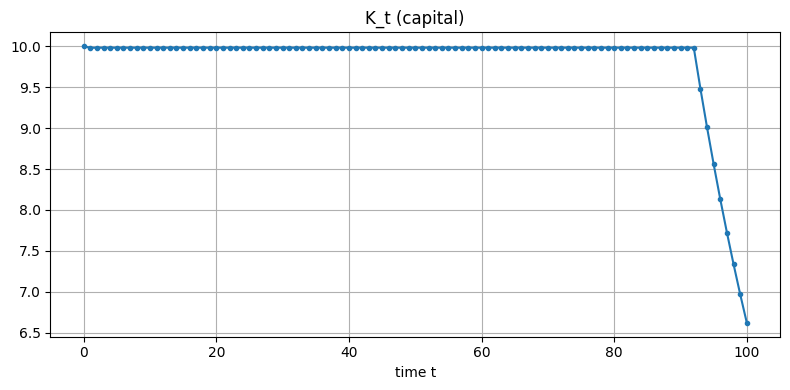

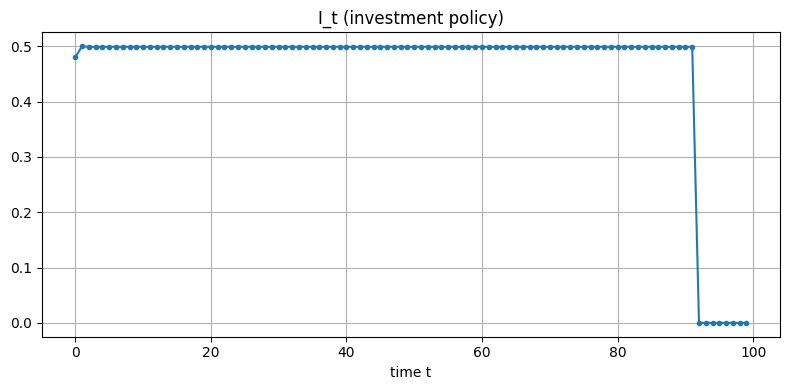

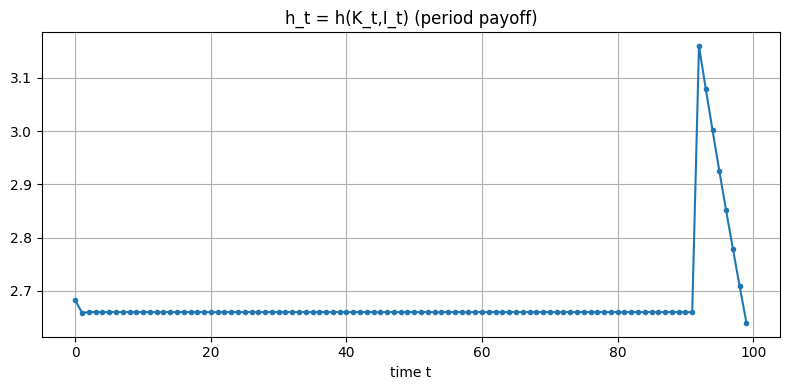

In [36]:
# set parameter values
A = 1.0
alpha = 0.5
beta = 0.98
Tsim = 100  # V[Tsim] is terminal value (set to 0, by the transversality condition under the condition we need capital stock positive at final period).
gamma_path = np.linspace(1, 1, Tsim)**2  # constant investment cost over time
delta_path = np.linspace(0.05, 0.05, Tsim)  # constant depreciation over time
K0 = 10  # choose initial capital within [Kmin, Kmax] - we want it to start high
Kmin, Kmax, nK = 0.1, 10.0, 100
Imin, Imax, nI = 0.0, 2.5, 100

# define payoff function depending on time t, h(K,I,t), vectorised in I (though we can put a scalar in too)
def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - gamma_t * I_grid

# define the law of motion function, dependent on time t
def K_next(K, I_grid, t):
    delta_t = delta_path[t]
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

---

Now do it in a way that incorporates increasing depreciation and increasing investment cost over time

Backward step done: t=90
Backward step done: t=80
Backward step done: t=70
Backward step done: t=60
Backward step done: t=50
Backward step done: t=40
Backward step done: t=30
Backward step done: t=20
Backward step done: t=10
Backward step done: t=0
Backward induction finished.


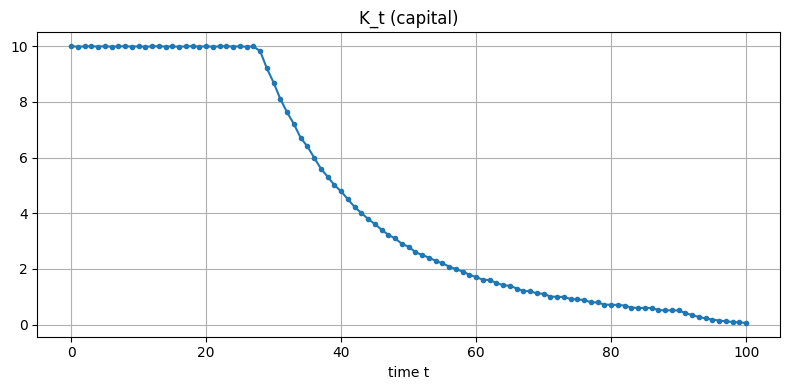

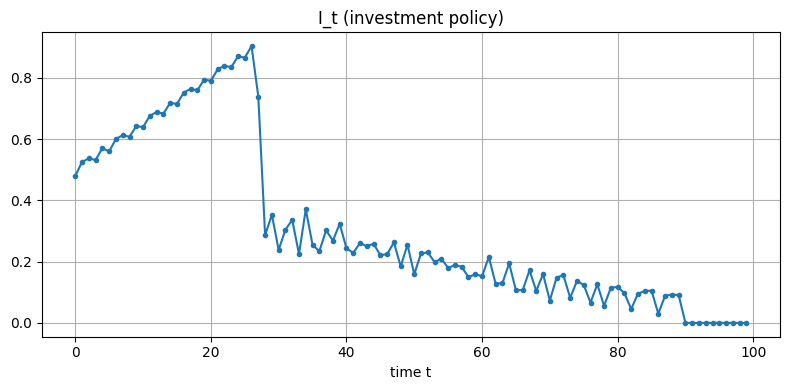

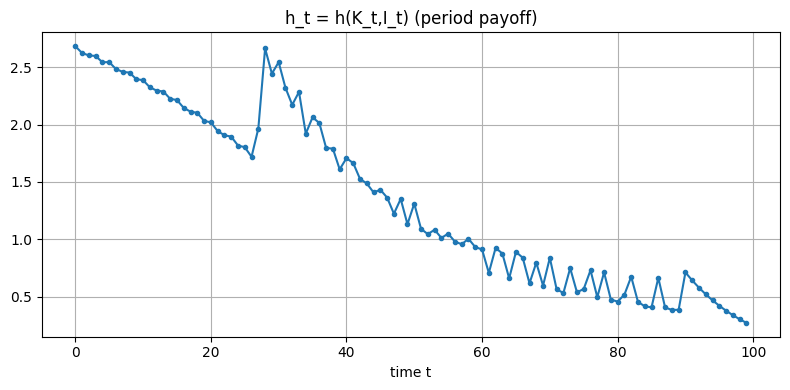

In [ ]:
# set parameter values
A = 1.0
alpha = 0.5
beta = 0.98
Tsim = 100  # V[Tsim] is terminal value (set to 0, by the transversality condition under the condition we need capital stock positive at final period).
gamma_path = np.linspace(1, 2, Tsim)**2  # increasing polynomial investment cost over time
delta_path = np.linspace(0.05, 0.2, Tsim)  # increasing depreciation over time
K0 = 10  # choose initial capital within [Kmin, Kmax] - we want it to start high
Kmin, Kmax, nK = 0.1, 10.0, 100
Imin, Imax, nI = 0.0, 2.5, 100

# define payoff function depending on time t, h(K,I,t), vectorised in I (though we can put a scalar in too)
def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - gamma_t * I_grid

# define the law of motion function, dependent on time t
def K_next(K, I_grid, t):
    delta_t = delta_path[t]
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)